# Preliminary entropy analysis for OLMo:7b models

I have generated 5 responses per prompt, for 5 gender_assumed prompts, for 4 variants of the model: [base, sft, dpo, rlvr]

In [1]:
import json
from pathlib import Path

root_dir = Path.cwd().parent
data_dir = root_dir / "data"
output_dir = data_dir / "olmo7b_results"
output_file = output_dir / "merged_final_results.jsonl"

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
# Read the output file and extract model_key and mean_entropy values
results = []

with open(output_file, 'r', encoding='utf-8') as f:
    for line in f:
        data = json.loads(line.strip())
        model_key = data.get('model_key')
        mean_entropy = data.get('entropy_analysis', {}).get('mean_entropy')
        
        results.append({
            'model_key': model_key,
            'mean_entropy': mean_entropy
        })

# Group by model_key
from collections import defaultdict
grouped_results = defaultdict(list)

for result in results:
    model_key = result['model_key']
    mean_entropy = result['mean_entropy']
    if mean_entropy is not None:  # Only include if entropy was tracked
        grouped_results[model_key].append(mean_entropy)

# Display results
for model_key, entropies in grouped_results.items():
    print(f"\n{model_key}: {len(entropies)} values")
    print(f"Mean entropies: {entropies}")



base: 25 values
Mean entropies: [0.6478431159071625, 0.896590956946214, 0.7236393554570775, 0.7882680943608285, 0.7161393082390229, 0.7909931105002761, 0.7342664076387883, 0.7504192930708329, 0.7486504250764847, 0.9575891940668225, 0.8786990907788277, 0.6556751548250517, 1.078149431521694, 1.00062117403994, 0.7616885631655653, 0.651327451299876, 0.7091035572687785, 0.8927897142991423, 0.7407586161792278, 0.8912226196875175, 0.7192216233164072, 0.9687957221269607, 0.886452106833458, 1.024167287958165, 0.6205688435972357]

dpo: 25 values
Mean entropies: [0.7575199170711615, 0.7453636311512916, 0.768604588674134, 0.7765354040193188, 0.7365812884498397, 0.8052331596822235, 0.8101809496034548, 0.838601981445657, 0.7399087556818995, 0.937408335998019, 0.7911700774326892, 0.721576831172885, 0.7619780182391453, 0.8854256564593379, 0.9006471845601967, 0.8361762699285827, 0.806869372006319, 0.796398553731354, 0.7462097007611252, 0.7817681986519286, 0.9058519824762818, 0.8151223699384476, 0.8120

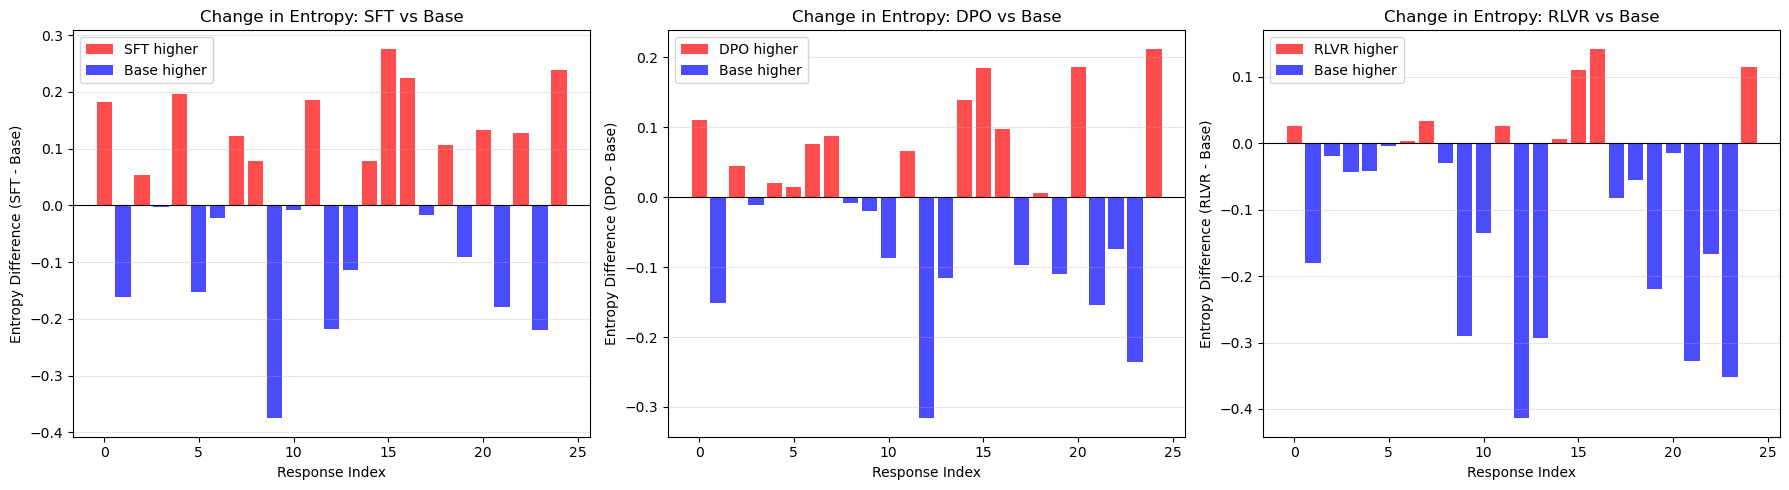


Summary Statistics:
SFT vs Base: Mean difference = 0.0178
DPO vs Base: Mean difference = -0.0054
RLVR vs Base: Mean difference = -0.0883


In [3]:
# Difference plots comparing base to each fine-tuned model
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

base_entropies = grouped_results['base']
models_to_compare = ['sft', 'dpo', 'rlvr']
model_labels = {'sft': 'SFT', 'dpo': 'DPO', 'rlvr': 'RLVR'}

for idx, model in enumerate(models_to_compare):
    ax = axes[idx]
    model_entropies = grouped_results[model]
    
    # Calculate differences
    differences = [model_entropies[i] - base_entropies[i] for i in range(len(base_entropies))]
    
    colors = ['red' if d > 0 else 'blue' for d in differences]
    bars = ax.bar(range(len(differences)), differences, color=colors, alpha=0.7)
    
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax.set_xlabel('Response Index')
    ax.set_ylabel(f'Entropy Difference ({model_labels[model]} - Base)')
    ax.set_title(f'Change in Entropy: {model_labels[model]} vs Base')
    ax.grid(axis='y', alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor='red', alpha=0.7, label=f'{model_labels[model]} higher'),
                       Patch(facecolor='blue', alpha=0.7, label='Base higher')]
    ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
for model in models_to_compare:
    differences = [grouped_results[model][i] - base_entropies[i] for i in range(len(base_entropies))]
    avg_diff = np.mean(differences)
    print(f"{model_labels[model]} vs Base: Mean difference = {avg_diff:.4f}")

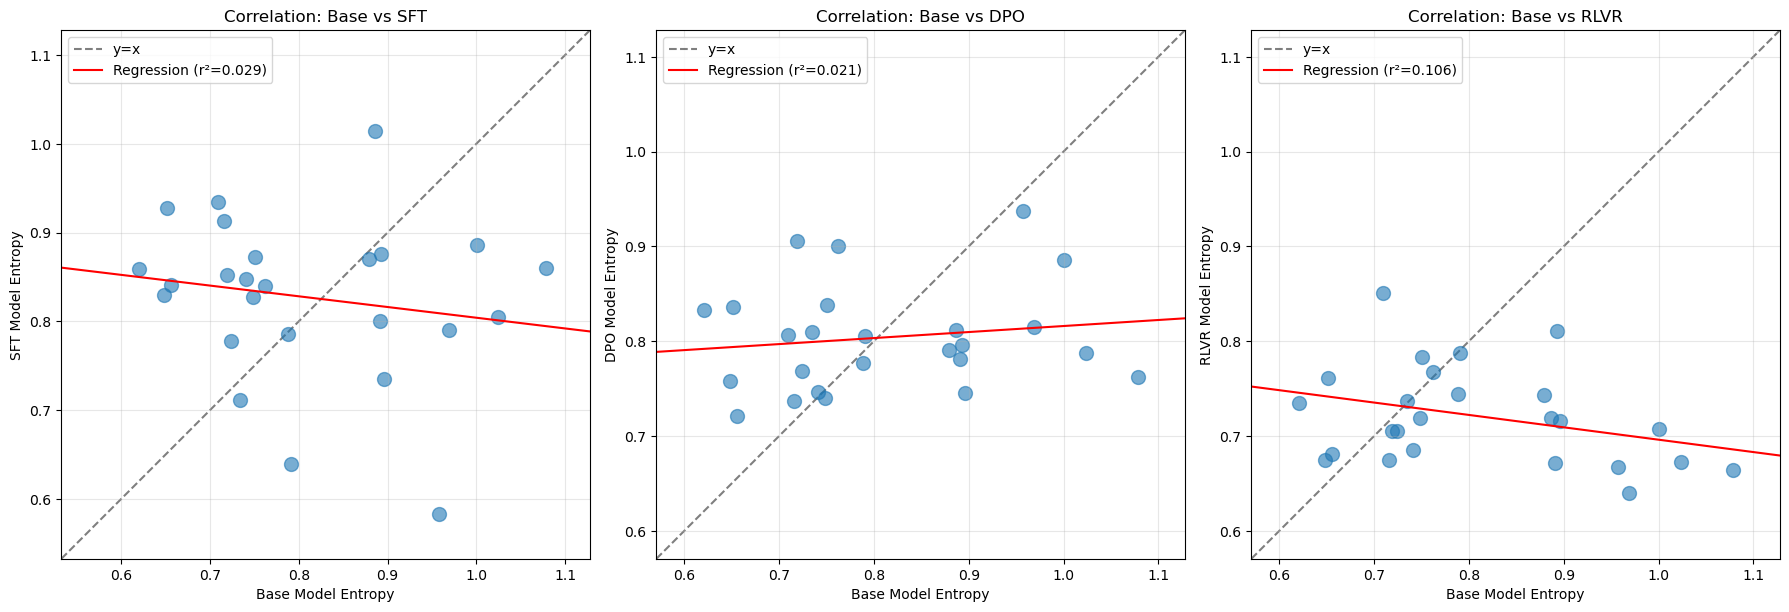

In [4]:
# Scatter plots with regression lines comparing base to each fine-tuned model
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

base_entropies = grouped_results['base']

for idx, model in enumerate(models_to_compare):
    ax = axes[idx]
    model_entropies = grouped_results[model]
    
    ax.scatter(base_entropies, model_entropies, s=100, alpha=0.6)
    
    # Add diagonal line (y=x)
    lims = [min(min(base_entropies), min(model_entropies)) - 0.05, 
            max(max(base_entropies), max(model_entropies)) + 0.05]
    ax.plot(lims, lims, 'k--', alpha=0.5, zorder=0, label='y=x')
    
    # Add regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(base_entropies, model_entropies)
    line_x = np.array(lims)
    line_y = slope * line_x + intercept
    ax.plot(line_x, line_y, 'r-', label=f'Regression (r²={r_value**2:.3f})')
    
    ax.set_xlabel('Base Model Entropy')
    ax.set_ylabel(f'{model_labels[model]} Model Entropy')
    ax.set_title(f'Correlation: Base vs {model_labels[model]}')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

plt.tight_layout()
plt.show()

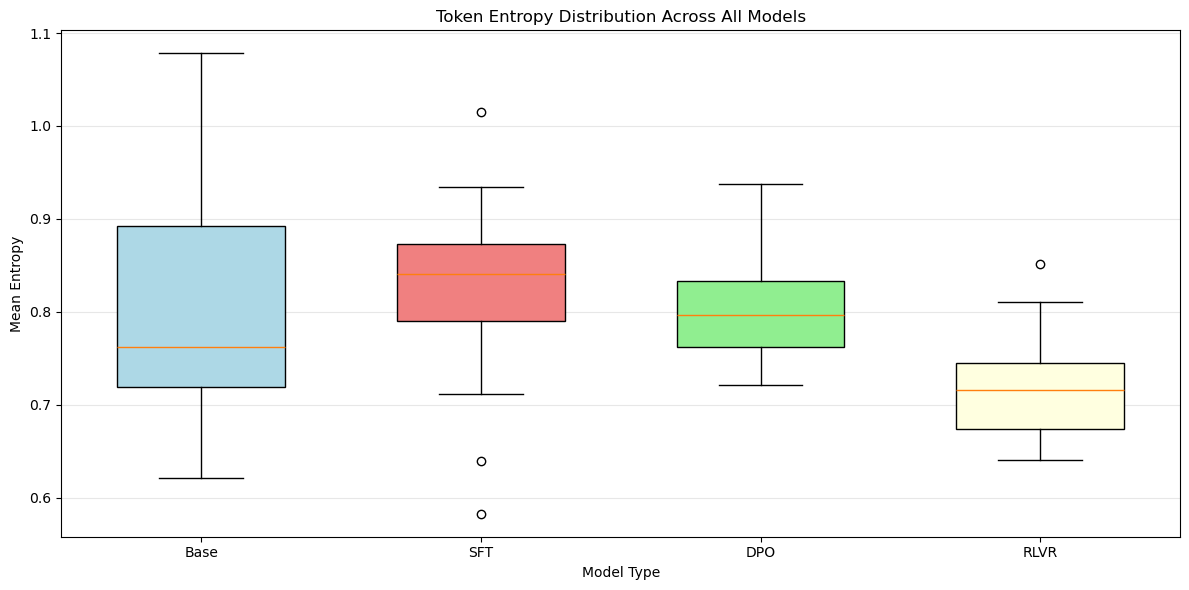


Overall Statistics:
BASE: mean=0.8093, std=0.1264, min=0.6206, max=1.0781
SFT: mean=0.8271, std=0.0897, min=0.5826, max=1.0150
DPO: mean=0.8039, std=0.0553, min=0.7216, max=0.9374
RLVR: mean=0.7210, std=0.0506, min=0.6404, max=0.8513


In [5]:
# Combined box plot comparing all models
fig, ax = plt.subplots(figsize=(12, 6))

positions = []
data_to_plot = []
colors = []
color_map = {'base': 'lightblue', 'sft': 'lightcoral', 'dpo': 'lightgreen', 'rlvr': 'lightyellow'}

for i, model_key in enumerate(['base', 'sft', 'dpo', 'rlvr']):
    positions.append(i)
    data_to_plot.append(grouped_results[model_key])
    colors.append(color_map[model_key])

bp = ax.boxplot(data_to_plot, positions=positions, widths=0.6, patch_artist=True)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_xlabel('Model Type')
ax.set_ylabel('Mean Entropy')
ax.set_title('Token Entropy Distribution Across All Models')
ax.set_xticks(positions)
ax.set_xticklabels(['Base', 'SFT', 'DPO', 'RLVR'])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print overall statistics
print("\nOverall Statistics:")
for model_key in ['base', 'sft', 'dpo', 'rlvr']:
    entropies = grouped_results[model_key]
    print(f"{model_key.upper()}: mean={np.mean(entropies):.4f}, std={np.std(entropies):.4f}, min={np.min(entropies):.4f}, max={np.max(entropies):.4f}")